In [100]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import folium
import flask
from flask import Flask
app = Flask(__name__)

%matplotlib inline

In [101]:
# Parse Log File
fp = '/home/mapper/VGI_Data/SeaID/csb3/20130829.log'
data = pd.read_csv(fp, sep='|', names=['Epoch', 'Depth', 'Lat', 'Long'])


In [102]:
# Remove observations with empty cells
data.replace(r'^\s*$', np.nan, regex=True, inplace=True)
data.dropna(inplace=True)


In [103]:
# Convert Latitude to Usable Format 

data['LatTemp'] = data['Lat'].str.split(' ').str.get(0) 
data['LongTemp'] = data['Long'].str.split(' ').str.get(0) 

data['LatN'] = pd.to_numeric(data['LatTemp'].str[0:2]) + (pd.to_numeric(data['LatTemp'].str[2:]) / 60)
data['LongN'] = pd.to_numeric(data['LongTemp'].str[0:3]) + (pd.to_numeric(data['LongTemp'].str[3:]) / 60)


# Convert Latitude to Usable Format
conditionsLat = [
    (data['Lat'].str.split(' ').str.get(1) == 'N'),
    (data['Lat'].str.split(' ').str.get(1) == 'S')] 

choicesLat = [data['LatN'], 
              -1 * data['LatN']]
data['LatDD'] = np.select(conditionsLat, choicesLat, default=np.nan)

# Convert Longitude to Usable Format
conditionsLong = [
    (data['Long'].str.split(' ').str.get(1) == 'E'),
    (data['Long'].str.split(' ').str.get(1) == 'W')] 

choicesLong = [data['LongN'], 
               -1 * data['LongN']]
data['LongDD'] = np.select(conditionsLong, choicesLong, default=np.nan)

if 'Lat' in data.columns:
    data = data.drop(['Lat', 'Long', 'LatTemp', 'LongTemp', 'LatN', 'LongN'], axis=1)

data.head()


,Epoch,Depth,LatDD,LongDD
0,1372440514,296.5,40.914833,19.005167
1,1372440570,294.0,40.910667,19.005167
2,1372440598,276.2,40.910167,19.005167
3,1372440610,296.0,40.909667,19.005167
4,1372440614,293.7,40.907667,19.005167


In [104]:
# Convert pandas to geodataframe
geometry = [Point(xy) for xy in zip(data.LongDD, data.LatDD)]
    
# Set Coordinate System to WGS84
crs = {'init': 'epsg:4326'}

geoData = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)
geoData.head()

,Epoch,Depth,LatDD,LongDD,geometry
0,1372440514,296.5,40.914833,19.005167,POINT (19.00516666666667 40.91483333333333)
1,1372440570,294.0,40.910667,19.005167,POINT (19.00516666666667 40.91066666666666)
2,1372440598,276.2,40.910167,19.005167,POINT (19.00516666666667 40.91016666666667)
3,1372440610,296.0,40.909667,19.005167,POINT (19.00516666666667 40.90966666666667)
4,1372440614,293.7,40.907667,19.005167,POINT (19.00516666666667 40.90766666666666)


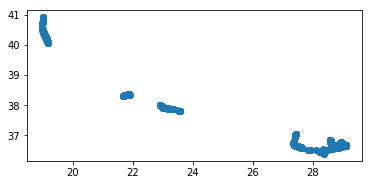

In [105]:
geoData.plot()

In [106]:
gjson = geoData.to_crs(epsg='4326').to_json()

map = folium.Map([38, 24],
                  zoom_start=7,
                  tiles='cartodbdark_matter')

points = folium.features.GeoJson(gjson)

map.add_children(points)
map.save('/home/mapper/VGI_Data/Maps/csb3_20130829.html')


<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><iframe src="data:text/html;base64,CiAgICAgICAgPCFET0NUWVBFIGh0bWw+CiAgICAgICAgPGhlYWQ+CiAgICAgICAgICAgIAogICAgICAgIAogICAgICAgICAgICA8bWV0YSBodHRwLWVxdWl2PSJjb250ZW50LXR5cGUiIGNvbnRlbnQ9InRleHQvaHRtbDsgY2hhcnNldD1VVEYtOCIgLz4KICAgICAgICAKICAgICAgICAgICAgCiAgICAgICAgCiAgICAgICAgICAgIDxzY3JpcHQgc3JjPSJodHRwczovL2NkbmpzLmNsb3VkZmxhcmUuY29tL2FqYXgvbGlicy9sZWFmbGV0LzAuNy4zL2xlYWZsZXQuanMiPjwvc2NyaXB0PgogICAgICAgIAogICAgICAgIAogICAgICAgIAogICAgICAgICAgICAKICAgICAgICAKICAgICAgICAgICAgPHNjcmlwdCBzcmM9Imh0dHBzOi8vYWpheC5nb29nbGVhcGlzLmNvbS9hamF4L2xpYnMvanF1ZXJ5LzEuMTEuMS9qcXVlcnkubWluLmpzIj48L3NjcmlwdD4KICAgICAgICAKICAgICAgICAKICAgICAgICAKICAgICAgICAgICAgCiAgICAgICAgCiAgICAgICAgICAgIDxzY3JpcHQgc3JjPSJodHRwczovL21heGNkbi5ib290c3RyYXBjZG4uY29tL2Jvb3RzdHJhcC8zLjIuMC9qcy9ib290c3RyYXAubWluLmpzIj48L3NjcmlwdD4KICAgICAgICAKICAgICAgICAKICAgICAgICAKICAgICAgICAgICAgCiAgICAgICAgCiAgICAgICAgICAgIDxzY3JpcHQgc3JjPSJodHRwczovL2NkbmpzLmNsb3VkZmxhcmUuY29tL2FqYXgvbGlicy9MZWFmbGV0LmF3ZXNvbWUtbWFya2Vycy8yLjAuMi9sZWFmbGV0LmF3ZXNvbWUtbWFya2Vycy5taW4uanMiPjwvc2NyaXB0PgogICAgICAgIAogICAgICAgIAogICAgICAgIAogICAgICAgICAgICAKICAgICAgICAKICAgICAgICAgICAgPHNjcmlwdCBzcmM9Imh0dHBzOi8vY2RuanMuY2xvdWRmbGFyZS5jb20vYWpheC9saWJzL2xlYWZsZXQubWFya2VyY2x1c3Rlci8wLjQuMC9sZWFmbGV0Lm1hcmtlcmNsdXN0ZXItc3JjLmpzIj48L3NjcmlwdD4KICAgICAgICAKICAgICAgICAKICAgICAgICAKICAgICAgICAgICAgCiAgICAgICAgCiAgICAgICAgICAgIDxzY3JpcHQgc3JjPSJodHRwczovL2NkbmpzLmNsb3VkZmxhcmUuY29tL2FqYXgvbGlicy9sZWFmbGV0Lm1hcmtlcmNsdXN0ZXIvMC40LjAvbGVhZmxldC5tYXJrZXJjbHVzdGVyLmpzIj48L3NjcmlwdD4KICAgICAgICAKICAgICAgICAKICAgICAgICAKICAgICAgICAgICAgCiAgICAgICAgCiAgICAgICAgICAgIDxsaW5rIHJlbD0ic3R5bGVzaGVldCIgaHJlZj0iaHR0cHM6Ly9jZG5qcy5jbG91ZGZsYXJlLmNvbS9hamF4L2xpYnMvbGVhZmxldC8wLjcuMy9sZWFmbGV0LmNzcyIgLz4KICAgICAgICAKICAgICAgICAKICAgICAgICAKICAgICAgICAgICAgCiAgICAgICAgCiAgICAgICAgICAgIDxsaW5rIHJlbD0ic3R5bGVzaGVldCIgaHJlZj0iaHR0cHM6Ly9tYXhjZG4uYm9vdHN0cmFwY2RuLmNvbS9ib290c3RyYXAvMy4yLjAvY3NzL2Jvb3RzdHJhcC5taW4uY3NzIiAvPgogICAgICAgIAogICAgICAgIAogICAgICAgIAogICAgICAgICAgICAKICAgICAgICAKICAgICAgICAgICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL21heGNkbi5ib290c3RyYXBjZG4uY29tL2Jvb3RzdHJhcC8zLjIuMC9jc3MvYm9vdHN0cmFwLXRoZW1lLm1pbi5jc3MiIC8+CiAgICAgICAgCiAgICAgICAgCiAgICAgICAgCiAgICAgICAgICAgIAogICAgICAgIAogICAgICAgICAgICA8bGluayByZWw9InN0eWxlc2hlZXQiIGhyZWY9Imh0dHBzOi8vbWF4Y2RuLmJvb3RzdHJhcGNkbi5jb20vZm9udC1hd2Vzb21lLzQuMS4wL2Nzcy9mb250LWF3ZXNvbWUubWluLmNzcyIgLz4KICAgICAgICAKICAgICAgICAKICAgICAgICAKICAgICAgICAgICAgCiAgICAgICAgCiAgICAgICAgICAgIDxsaW5rIHJlbD0ic3R5bGVzaGVldCIgaHJlZj0iaHR0cHM6Ly9jZG5qcy5jbG91ZGZsYXJlLmNvbS9hamF4L2xpYnMvTGVhZmxldC5hd2Vzb21lLW1hcmtlcnMvMi4wLjIvbGVhZmxldC5hd2Vzb21lLW1hcmtlcnMuY3NzIiAvPgogICAgICAgIAogICAgICAgIAogICAgICAgIAogICAgICAgICAgICAKICAgICAgICAKICAgICAgICAgICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL2NkbmpzLmNsb3VkZmxhcmUuY29tL2FqYXgvbGlicy9sZWFmbGV0Lm1hcmtlcmNsdXN0ZXIvMC40LjAvTWFya2VyQ2x1c3Rlci5EZWZhdWx0LmNzcyIgLz4KICAgICAgICAKICAgICAgICAKICAgICAgICAKICAgICAgICAgICAgCiAgICAgICAgCiAgICAgICAgICAgIDxsaW5rIHJlbD0ic3R5bGVzaGVldCIgaHJlZj0iaHR0cHM6Ly9jZG5qcy5jbG91ZGZsYXJlLmNvbS9hamF4L2xpYnMvbGVhZmxldC5tYXJrZXJjbHVzdGVyLzAuNC4wL01hcmtlckNsdXN0ZXIuY3NzIiAvPgogICAgICAgIAogICAgICAgIAogICAgICAgIAogICAgICAgICAgICAKICAgICAgICAKICAgICAgICAgICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL3Jhdy5naXRodWJ1c2VyY29udGVudC5jb20vcHl0aG9uLXZpc3VhbGl6YXRpb24vZm9saXVtL21hc3Rlci9mb2xpdW0vdGVtcGxhdGVzL2xlYWZsZXQuYXdlc29tZS5yb3RhdGUuY3NzIiAvPgogICAgICAgIAogICAgICAgIAogICAgICAgIAogICAgICAgICAgICAKICAgICAgICAgICAgPHN0eWxlPgoKICAgICAgICAgICAgaHRtbCwgYm9keSB7CiAgICAgICAgICAgICAgICB3aWR0aDogMTAwJTsKICAgICAgICAgICAgICAgIGhlaWdodDogMTAwJTsKICAgICAgICAgICAgICAgIG1hcmdpbjogMDsKICAgICAgICAgICAgICAgIHBhZGRpbmc6IDA7CiAgICAgICAgICAgICAgICB9CgogICAgICAgICAgICAjbWFwIHsKICAgICAgICAgICAgICAgIHBvc2l0aW9uOmFic29sdXRlOwogICAgICAgICAgICAgICAgdG9wOjA7CiAgICAgICAgICAgICAgICBib3R0b206MDsKICAgICAgICAgICAgICAgIHJpZ2h0OjA7CiAgICAgI